In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import pandas as pd
import numpy as np

import random
import datetime
import time
from matplotlib import pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from tqdm import tqdm


In [3]:
def read_sentiment_data():
    df = pd.read_excel("data/THY_SA_Dataset.xlsx")
    df = df.loc[df["Sentiment"].isin(["neutral", "negative", "positive"])]
    return df

In [4]:
df_sentiments = read_sentiment_data()
display(df_sentiments.head())
df_sentiments.drop(columns=["Date", "Language", "Tags"])
df_sentiments["Content"] = df_sentiments["Content"].str.replace("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", "")
df_sentiments["Content"] = df_sentiments["Content"].str.replace("(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9-_]+)", "")
df_sentiments["Content"] = df_sentiments["Content"].str.replace(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "")
#df_sentiments["Content"] = df_sentiments['Content'].str.replace("[^a-zA-Z#öüçğşıÖÜÇĞŞİ]", " ")
df_sentiments["Content"] = df_sentiments["Content"].replace("\n", "", regex=True)
df_sentiments["Content"] = df_sentiments["Content"].str.strip()

trans = str.maketrans("ÖÜŞÇĞİ", "öüşçği")
df_sentiments["Content"] = df_sentiments["Content"].str.translate(trans).str.lower()

df_sentiments.head()

,Content,Date,Language,Sentiment,Tags
0,@TK_HelpDesk Özel mesaj attım size,2021-05-28,tr,neutral,"mim, Rezervasyon, TR, Yorum"
1,\n \n Gurbet...,2021-05-26,tr,negative,"Bilet Fiyati, Kontrol Edildi, mim, Mim Post Yo..."
2,Yoğunluk #thy,2021-04-26,tr,negative,"Cagri Merkezi islemleri, mim, Reporting, TR, Y..."
3,Daha bir ay önce kırdığınız valizimin yerine ...,2021-02-01,tr,negative,"Hasarli Bagaj, Kontrol Edildi, mim, TR, Yorum"
4,@TK_HelpDesk Çalışma arkadaşlarınız gerekli ha...,2021-02-02,tr,positive,"Hasarli Bagaj, Kontrol Edildi, mim, TR, Yorum"


/var/folders/sr/r72219hj06x_1xvw7hhd517h0000gn/T/ipykernel_37995/1520805587.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_sentiments["Content"] = df_sentiments["Content"].str.replace("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", "")
/var/folders/sr/r72219hj06x_1xvw7hhd517h0000gn/T/ipykernel_37995/1520805587.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_sentiments["Content"] = df_sentiments["Content"].str.replace("(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9-_]+)", "")
/var/folders/sr/r72219hj06x_1xvw7hhd517h0000gn/T/ipykernel_37995/1520805587.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_sentiments["Content"] = df_sentiments["Content"].str.replace(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "")


,Content,Date,Language,Sentiment,Tags
0,özel mesaj attım size,2021-05-28,tr,neutral,"mim, Rezervasyon, TR, Yorum"
1,gurbetçiler bu sene arabayla gidiyor vatanları...,2021-05-26,tr,negative,"Bilet Fiyati, Kontrol Edildi, mim, Mim Post Yo..."
2,yoğunluk,2021-04-26,tr,negative,"Cagri Merkezi islemleri, mim, Reporting, TR, Y..."
3,daha bir ay önce kırdığınız valizimin yerine ...,2021-02-01,tr,negative,"Hasarli Bagaj, Kontrol Edildi, mim, TR, Yorum"
4,çalışma arkadaşlarınız gerekli hassasiyeti gös...,2021-02-02,tr,positive,"Hasarli Bagaj, Kontrol Edildi, mim, TR, Yorum"


In [5]:
pos = df_sentiments.loc[df_sentiments["Sentiment"].isin(["positive"])]
neg = df_sentiments.loc[df_sentiments["Sentiment"].isin(["negative"])]
neut = df_sentiments.loc[df_sentiments["Sentiment"].isin(["neutral"])]
concat = pd.concat([pos.sample(n=745, random_state=54), neg.sample(n=745 + 100, random_state=54), neut.sample(n=745 + 100, random_state=54)]).sample(frac=1, random_state=54)
concat["Sentiment"].value_counts()

neutral     845
negative    845
positive    745
Name: Sentiment, dtype: int64

In [6]:
concat.head()

,Content,Date,Language,Sentiment,Tags
8131,slm ben fransada ikamet ediyorum . ama genevre...,2021-07-09,tr,neutral,"Belge - PCR - Aşı, cozumlendi, mim, Mim Post Y..."
16093,#türkhavayolları tk2337 sefer sayılı izmir ...,2021-03-03,tr,negative,"mim, TR, Yorum, Zamaninda Kalkis - Varis (Rotar)"
22813,allah razi olsun çok taşakkür ederim sağ olun.,2021-02-23,tr,positive,"Evcil Hayvan, Kontrol Edildi, Kontrol Ettim, m..."
14653,yurt disi ucuslar devam edecek mi? bileti olan...,2021-04-26,tr,neutral,"mim, Mim Post Yorum, Rezervasyon, TR"
8213,tesekkur ediyorum..,2021-04-27,tr,neutral,"mim, Rezervasyon, TR, Yorum, Yuksek Takipci"


In [7]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=False)

In [8]:
training = concat.groupby('Sentiment').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([concat,training]).drop_duplicates(keep=False)

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.Content.values
training_labels = training.Sentiment.values

test_texts = test.Content.values
test_labels = test.Sentiment.values

coder = LabelEncoder()
coder.fit(training_labels)
training_labels = coder.transform(training_labels)
test_labels = coder.transform(test_labels)

Training:  1948
Test:  374


In [9]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = 128,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/berkayg/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  merhaba, kıbrıs dönüş biletim için bir tarife değişikliği olmuştu.bu değişiklik nedeniyle yeni bilet basımı gerçekleşecekti ancak 24 saat geçmesine rağmen tarafıma herhangi bir bilgilendirme maili gelmedi.konu ile ilgili bilgi verilmesini rica ederim.
Token IDs: tensor([     2,   5389,     16,   4410,   3312, 110423,   2013,   1947,  18902,
          8127,   8326,     18,   1964,   4384,   3426,   2262,   6138,  39688,
         11996,   2015,   2591,   3444,   2625,  19641,   3611,  50103,   3485,
          1947,  11039,  54295,  13125,     18,   2580,   2037,   2516,   2990,
         15766,  10203,   4910,     18,      3,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
      

In [10]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = len(concat['Sentiment'].unique())

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)
device = torch.device("mps")
model.to(device);



Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

In [11]:

epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/Users/berkayg/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        output = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 2 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 3 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
======== Epoch 4 / 4 ========
Average training loss: 0.00
Training epoch took: 0:00:01
Training completed in 0:00:05 (h:mm:ss)


In [18]:
b_input_ids.shape

torch.Size([32, 128])

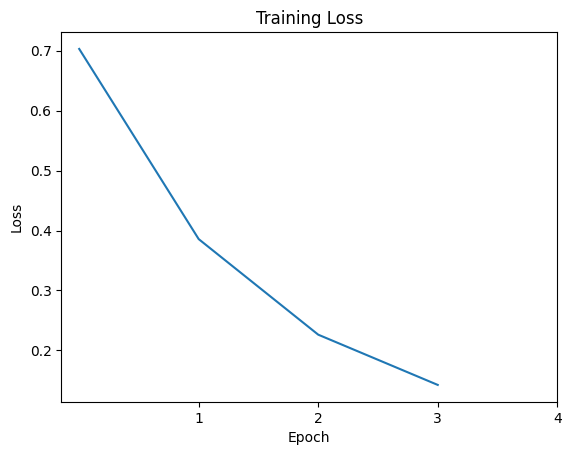

In [80]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [270]:
input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = 128,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/Users/berkayg/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [271]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [272]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
# report = report.rename(columns={'0':'dunya',
#                           '1':'ekonomi',
#                           '2':'kultur',
#                           '3':'saglik',
#                           '4':'siyaset',
#                           '5':'spor',
#                           '6':'teknoloji'})

print(classification_report(test_labels, prediction_scores))

F-Score:  0.902143622743471
Recall:  0.9181940221723224
Precision:  0.8918728155010349
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       156
           1       0.97      0.87      0.92       158
           2       0.81      0.94      0.87        49

    accuracy                           0.91       363
   macro avg       0.89      0.92      0.90       363
weighted avg       0.92      0.91      0.91       363



In [210]:
le_name_mapping = dict(zip(coder.classes_, coder.transform(coder.classes_)))
le_code_mapping = dict(zip(coder.transform(coder.classes_), coder.classes_))
def prediction_pipeline(text):
    input_ids = []
    attention_masks = []
    text = text.replace("\n", " ").strip()
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = 128,          
                        padding = "max_length",
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    with torch.no_grad():
        device_input_ids = input_ids.to(device)
        device_attention_masks = attention_masks.to(device)
        outputs = model(device_input_ids, token_type_ids=None, 
                        attention_mask=device_attention_masks)

    logits = outputs[0]
    # logits = logits.detach().cpu().numpy()
    probs = F.softmax(logits[0], dim=0)
    probs = probs.detach().cpu().numpy()
    label = np.argmax(probs, axis=0).flatten()
    prob = np.max(probs, axis=0).flatten()[0]
    prob = round(prob, 5)
    print(f"Text:\n{text}\n\nLabel: {le_code_mapping[label[0]]}\nProb: {prob:.2f}")


In [226]:
text = """müşteri hizmetlerine bağlanmak için 28 dakikadır telefonda bekleten firma. aramanın alınma sırasına göre telefonlara cevap verildiğini söylediklerini de dikkate alırsak tüm türkiye ile 5 kişi falan görüşmeye çalışıyor sanırım yoksa mantıklı bir açıklaması yok. 7 gün 24 saat müşteri hizmetleri taahüdünü kesinlikle yerine getirmeyen şirkettir."""
prediction_pipeline(text)

Text:
müşteri hizmetlerine bağlanmak için 28 dakikadır telefonda bekleten firma. aramanın alınma sırasına göre telefonlara cevap verildiğini söylediklerini de dikkate alırsak tüm türkiye ile 5 kişi falan görüşmeye çalışıyor sanırım yoksa mantıklı bir açıklaması yok. 7 gün 24 saat müşteri hizmetleri taahüdünü kesinlikle yerine getirmeyen şirkettir.

Label: negative
Prob: 0.99


In [113]:
print(le_name_mapping)

{'negative': 0, 'neutral': 1, 'positive': 2}


In [278]:
torch.save(model.state_dict(), "model/Turkish-SA.pth")

In [289]:
deneme_model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)
deneme_model.to(device)
for param in deneme_model.parameters():
    param.required_grad = False

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

In [290]:
deneme_model.load_state_dict(torch.load("model/Turkish-SA.pth"))
deneme_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [292]:
le_name_mapping = dict(zip(coder.classes_, coder.transform(coder.classes_)))
le_code_mapping = dict(zip(coder.transform(coder.classes_), coder.classes_))
def prediction_pipeline(text):
    input_ids = []
    attention_masks = []
    text = text.replace("\n", " ").strip()
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = 128,          
                        padding = "max_length",
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                    )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    with torch.no_grad():
        device_input_ids = input_ids.to(device)
        device_attention_masks = attention_masks.to(device)
        outputs = deneme_model(device_input_ids, token_type_ids=None, 
                        attention_mask=device_attention_masks)

    logits = outputs[0]
    # logits = logits.detach().cpu().numpy()
    probs = F.softmax(logits[0], dim=0)
    probs = probs.detach().cpu().numpy()
    label = np.argmax(probs, axis=0).flatten()
    prob = np.max(probs, axis=0).flatten()[0]
    prob = round(prob, 5)
    print(f"Text:\n{text}\n\nLabel: {le_code_mapping[label[0]]}\nProb: {prob:.2f}")
prediction_pipeline("harika içerik")

Text:
harika içerik

Label: positive
Prob: 0.99


In [293]:
# torch.save(model, "model/Turkish-SA-model.pth")

In [295]:
le_code_mapping

{0: 'negative', 1: 'neutral', 2: 'positive'}